# Text Mining on Amazon Fine Food Reviews
## Filter Out Users Who Improve Their Review Quality Over Time

GWU 2019 Fall DATS_6450 Natural Language Processing <br/>
Project Group Member: Naixin Zhu <br/>
December 9, 2019

### Literature

The research is inspired by _"From Amateurs to Connoisseurs: Modeling the Evolution of User Expertise through Online Reviews"_ (McAuley and Leskovec 2013).  The paper uses an Amazon Fine Food Review dataset and filter out users whose taste improve over time. The purpose of the study is targeting the subsection of the population according to their evolving level of taste. For example, a novice wine consumer would be attracted to different wine from connoisseurs. 

McAuley and Leskovec's research used a latent variable model, which they assume the experience level is a latent variable, and set a constraint that experience is a monotonically increasing function of time. The study incorporates four different designs of the latent models: the first model has parameters evolve for the entire community as a function of time; the second model has parameters evolve independently for each user; the third model has parameters evolve for the entire community as a function of time, where the ‘stages’ of evolution are learned and the fourth model has parameters evolve independently for each user, where the stages of evolution are learned. Their study found that connoisseur's behavior are more predictable than beginners, they agree more among themselves than beginners and they rate good products more generously while bad products more harshly than beginners. 

For my research, I will solve the same question: filtering out the reviewers who improve over time. I may not be able to identify the subsection of improving reviewers, but I will be able to separate them from consistently good, or bad, or deteriorating reviewers. Unlike McAuley and Leskovec study, I will not make any assumptions about the underlying distribution of the improving users, and my design follows a pure practical approach. 

### Methodology

The original dataset contains 204,865 comments, which belong to 74,258 unique products and 256,059 unique users. In my analysis, I deleted products which has only 1 comment, and users who wrote less than 3 comments. In order to distinguish high quality reviews from low quality ones, I assume the former possess the following characteristics:
* chronologically, higher quality comments always comes later as the user improves over time. 
* higher quality comments contain more complex sentences
* higher quality comments are generally longer
* assuming the last comment of an improving user is the best, then the similarity scores between the first comment of the user and every subsequent comment will decrease. The higher the similarity score, the more alike the two comments are. So I expect, as an improving user, his later comments grow less and less similar to his initial comment. 

In addition to above three criteria, I created a helpfulness index for checking whether the filtered group of users are indeed the improving users. The helpfulness index is normalized between 0 and 1, the closer to 1, the more helpful the comment is. The numerator is the number of clicks on the 'helpful' button under the comment. The original denominator is the sum of numerator and the number of clicks on the 'unhelpful' button. However, Amazon deleted the 'unhelpful' button about two years ago. Thus, the denominator values are not reliable for the recent 2 years. I came up with my own version of helpfulness denominator, which is the number of total comments of the product. 

#### 1. Import Necessary Packages

In [3]:
import os
cwd = os.getcwd() 
# If not in the right directory, change it below
os.chdir(cwd)
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import pandas as pd
import spacy
import numpy as np
import re
import pickle
nlp = spacy.load("en_core_web_md")
from scipy import stats
from scipy.stats import scoreatpercentile
from scipy.stats import percentileofscore
from sklearn import preprocessing
from langdetect import detect
import seaborn as sns
import json
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%matplotlib inline
import seaborn as sns

#### 2. Clean the Original Dataset

The dataset by published by Stanford Network Analysis Project Now I take a look at number of unique products and users in the dataset. I dropped products with only 1 comment and users who have only written 1 review. Later, I will further drop users who have only written 2 reviews because in such case there is only 1 similarity score. I also dropped duplicate comments. Two comments are duplicates if they are posted at the exact same time by one user, and their exact text length are the same. 

The original dataset contains 256,059 unique users and 74,258 unique products. 

In [4]:
# import the original dataset in its csv file
df1 = pd.read_csv('Reviews.csv') 

# The number of unique User ID are 256,059
print(df1['UserId'].value_counts())

# The number of unique product ID are 74,258
print(df1['ProductId'].value_counts())

# Convert the unix time to datetime object
df1['Datetime'] = df1['Time'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

# Delete users who have written only one comment
# Delete products with only 1 review
df1['#_comments_per_product'] = df1.groupby('ProductId')['Id'].transform("count")
df1['#_comments_per_user'] = df1.groupby('UserId')['Id'].transform("count")
df2 = df1[(df1['#_comments_per_product'] > 1) & (df1['#_comments_per_user'] > 1)]

# Some entries are duplicates
# Identify duplicated comments by user_id, number of letter characters in the comment and the 
# exact time the comment is posted.
df2['len_of_text'] = df2['Text'].apply(lambda x: len(x))
df2 = df2.drop_duplicates(subset=['UserId', 'len_of_text', 'Time'])

A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
                 ... 
A30BGCBXHB0TUR      1
A1GZI5QK7EURUV      1
A304933U8Y14R4      1
A2MB7ZIINKGPY1      1
A3JURT1NU1IBIB      1
Name: UserId, Length: 256059, dtype: int64
B007JFMH8M    913
B002QWP89S    632
B002QWHJOU    632
B0026RQTGE    632
B002QWP8H0    632
             ... 
B006WQNGV6      1
B000612XM6      1
B004XUGORQ      1
B007O0KABS      1
B003J9SGTG      1
Name: ProductId, Length: 74258, dtype: int64


#### 3. Create Helpfulness Score

The helpfulness score aims to objectively measure whether a comment is helpful from consumers' point of view. In this study, high quality reviews are suppose to be helpful. Thus, this score can be a rubric for evaluating whether I successfully filtered users who write better reviews over time. 

In [5]:
# Create the helpfulness index as an objective measure of review quality
df2['helpfulness_score'] = df2['HelpfulnessNumerator']/df2['#_comments_per_product']

# Normalize the helpfulness index using MinMax Scaler
scaler = preprocessing.MinMaxScaler()
x = np.array(df2['helpfulness_score']).reshape(-1,1)
norm_x = scaler.fit_transform(x)
df2['norm_helpfulness_score'] = norm_x

#### 4. Create User Comment Dictionary

For the convenience of further analyses, I put one user's information into a dictionary, which include his/her reviews sorted in chronological order, the time of each review and normalized helpfulness scores. The dictionaries are then put into a list user_comments, which contains 79,793 unique users. 

In [6]:
# Get the list of unique user ids from the cleaned dataset
unique_user_ids = list(df2.UserId.unique())

# Select the columns I am going to keep
df3 = df2[['UserId', 'Text', 'norm_helpfulness_score', 'Datetime']]

# Convert one user's columns into a dictionary
# and arrange reviews in chronological order
# Put all users' information into a list of dictionaries
def get_unique_user_id_dict(x):
    user_comments = []
    for i in x:
        y =  df3[ df3['UserId'] == i ]
        y = y.sort_values(by=['Datetime'])
        y.reset_index(drop = True, inplace = True)
        y.rename(columns={'Text': i}, inplace=True)
        y.drop(['UserId'], axis=1, inplace = True)
        z = y.to_dict()
        user_comments.append(z)
    return user_comments

user_comments = get_unique_user_id_dict(unique_user_ids)

# save user_comments to cwd
with open('user_comments.pickle', 'wb') as filename:
    pickle.dump(user_comments, filename)

#### 5. Filter Users by Review Length, Average Dependence Parse Tree Height and Similarity Scores

##### 5.1 Function to Calculate Average Dependence Parse Tree Height

One can use either height of dependency parse tree or abstract syntactic tree to measure sentence complexity. In some cases, abstract syntax tree could be a better measure of sentence complexity. Unlike parse tree which includes every single word, such as 'a', 'the', 'of', in its structure, syntax trees ignore those small tokens because the relationship are usually incorporated into tree graph. However, dependency parse tree is easier to code. If I had more time, I will use abstract syntax tree as the criteria for measuring sentence complexity. 

In [7]:
# Copied from GitHub 
# https://gist.github.com/drussellmrichie/47deb429350e2e99ffb3272ab6ab216a

def tree_height(root):
    """
    Find the maximum depth (height) of the dependency parse of a spacy sentence by starting with its root
    Code adapted from https://stackoverflow.com/questions/35920826/how-to-find-height-for-non-binary-tree
    :param root: spacy.tokens.token.Token
    :return: int, maximum height of sentence's dependency parse tree
    For the meaning of children, please refer to https://spacy.io/api/token
    root is a spacy token object
    It measures the sentence complexity, the larger the number, the more complex the sentence is. 
    """
    if not list(root.children):
        return 1
    else:
        return 1 + max(tree_height(x) for x in root.children)

##### 5.2 Arrange User's Tree Height, Similarity Scores and Length into A Dictionary

Put one user's metrics: average dependency tree height, number of word tokens in a review, the similarity scores between one user's earliest review and his/her subsequent reviews into a dictionary. Combine all users' dictionaries into a parent dictionary: user_metrics. The purpose of doing this is to make further filtering more convenient. The user_metrics, which is also the base group users, contains 19,660 unique users. 

One should note that similarity score here takes the average of word similarity scores of comparing words in review A to words in review B. This score may be misleadingly high because it is a common case one have more or less the same words in two paragraphs, but the meaning could be very different. Thus, if I had more time, I should do text pre-processing because applying Spacy similarity method. 

In [8]:
user_metrics = {}

for user in user_comments:

    one_user_metrics = {}

    for key, value in user.items():

        if key == 'norm_helpfulness_score':
            one_user_metrics.update({ 'norm_helpfulness_score' : np.array(list(value.values())) })

        elif key == 'Datetime':
            one_user_metrics.update({'Datetime' : np.array(list(value.values()))})

        else:
            if len( value ) > 2:
                reviews_spacy_docs = {}
                doc_len_arr = np.array([])
                ave_tree_height_arr = np.array([])

                for text_id, user_texts in value.items():

                    if detect(user_texts) == 'en':
                        doci = nlp( user_texts )
                        reviews_spacy_docs.update({ text_id :  doci})
                    
                        # find the number of tokens in each comment and store them in a numpy array
                        doci_len = len( doci )
                        doc_len_arr = np.append( doc_len_arr, doci_len )

                        # find the average height of dependency parse tree of sentences in each comment, and store them in a numpy array
                        doci_roots = [sent.root for sent in doci.sents]
                        tree_height_arr = [tree_height(root) for root in doci_roots]
                        ave_tree_height = np.mean(tree_height_arr)
                        ave_tree_height_arr = np.append( ave_tree_height_arr, ave_tree_height )
                        
                        # enter the last loop of i, the latest comment in the sequence
                        # find the similarity score between the first comment and every other subsequent comment
                        if text_id == len( value ) - 1:
                            try: 
                                one_users_similarity_scores = np.array([])                        
                                for j in range(1, len( value )):
                                    x = reviews_spacy_docs[0].similarity( reviews_spacy_docs[j] )
                                    one_users_similarity_scores = np.append(one_users_similarity_scores, x)
                            except KeyError:
                                print(key)

                            one_user_metrics.update( { 'similarity_scores' : one_users_similarity_scores } )

                            # store the array of doc_len
                            one_user_metrics.update( { 'doc_len' : doc_len_arr } )

                            # store the array of average dependency tree heights
                            one_user_metrics.update( { 'tree_height' : ave_tree_height_arr } )

                            ## Store one user's metrics into the user metrics dictionary
                            user_metrics.update({ key : one_user_metrics })

                            
# save user_metrics to cwd 
with open('user_metrics.pickle', 'wb') as filename:
    pickle.dump(user_metrics, filename)

A2WVF9ZQ068DN0
AAUICTIUBVU7R
A1CNMLLMYNE26K
A3FN2UNQ8HB2OA
A3U7JXTZJWRQFL
A3UDKITOUIPHQ
A2BYMZ09DS2T0B
A17NBI5YTG67BA
A12PH6L5QSVTYN
A30QIRX0TROA6A
A39LN7ICUCWP22
A3J5IKBQOHNJ8G
A1W9C4TZA5YCBL
A2M069CN0QEW5N
A2ENQE2X5KJDUN
A2A65SC9WWJDRH
A1EHLYZET9M5LA
A2JGKIAAW9FK17
A2FMOP7ZXAK5F9
A2YIZ3AJUHEY6G


#### 6. Algorithm to Filter the Improving Users

##### 6.1 Functions that Detect Whether an Array is Increasing or Decreasing

According to the criteria explained before, I expect improving users to have longer reviews, more complex sentence structures and lower similarity scores as compared to the earliest review as the user improves. Thus, I need to write functions that can determine whether a numpy array has a decreasing or increasing trend. Note that they do not have to be monotonically increasing or decreasing, because the scores fluctuate over time. As long as I discover an increasing trend in review length, I can detect this user as improving user. I have added the date function just to ensure the reviews are listed in a chronological order. 

In [9]:
def increasing(arr):
    """
    function check whether elements in a numpy array largely follow a 
    monotonically increasing patttern
    (used for token length, average parse tree height and normalized helpfulness score)
    The closer the increasing score is to 1, the more likely 
    the sequence is monotonically increasing.

    ---- input is an numpy array ----
    """
    increasing_score_numerator = 0
    increasing_score_denominator = 0

    for i in range(len(arr)-1):
        for j in range(i+1, len(arr)):
            if arr[j] > arr[i]:
                increasing_score_numerator += 1
                increasing_score_denominator += 1
            else:
                increasing_score_numerator += 0
                increasing_score_denominator += 1

    increasing_score = increasing_score_numerator / increasing_score_denominator
    
    return increasing_score




def decreasing(arr):
    """
    function check whether elements in a numpy array largely follow a 
    monotonically decreasing patttern
    (used for similarity score)
    The closer the decreasing score is to 1, the more likely 
    the sequence is monotonically decreasing.

    ---- input is an numpy array ----
    """
    decreasing_score_numerator = 0
    decreasing_score_denominator = 0

    for i in range(len(arr)-1):
        for j in range(i+1, len(arr)):
            if arr[j] < arr[i]:
                decreasing_score_numerator += 1
                decreasing_score_denominator += 1
            else:
                decreasing_score_numerator += 0
                decreasing_score_denominator += 1

    decreasing_score = decreasing_score_numerator / decreasing_score_denominator
    
    return decreasing_score




def increasing_dates(arr):
    """
    function check whether datetime objects in a numpy array largely follow a 
    monotonically increasing patttern, which means the earlier dates
    come first in the array, and later dates follow. 
    The closer the score is to 1, the more likely 
    the sequence is monotonically increasing.

    since we already made the dates follow this order, 
    this is only double checking and ensuring the dates are
    indeed increasing. 

    ---- input is an numpy array filled with datetime objects ----
    """
    date_score_numerator = 0
    date_score_denominator = 0

    for i in range(len(arr)-1):
        for j in range(i+1, len(arr)):
            if arr[j] >= arr[i]:
                date_score_numerator += 1
                date_score_denominator += 1
            else:
                date_score_numerator += 0
                date_score_denominator += 1

    date_score = date_score_numerator / date_score_denominator
    
    return date_score
    

##### 6.2 Filter the Improving Users by Different Criteria

After defining the function for determining numpy array with decreasing or increasing trends, I apply them to the arrays in each user's metrics. The closer the score to 1 is, the more monotonic the increasing or decreasing trend is. Since I do not require the trend to be strictly increasing or decreasing, I set the threshold at 0.5. Since I sorted by Datetime before turning the dataframe into user_comments dictionary, I expect Datetime to be strictly increasing, thus I set the threshold for Datetime as 1. 

The improving users filtered by similarity score criteria contains 10,904 unique users.
The improving users filtered by number of tokens criteria contains 7,620 unique users.
The improving users filtered by average dependency parse tree height criteria contains 8,324 unique users. 
The improving users filtered (not exactly, because Datetime has already been sorted) by increasing Datetime criteria contains 19,648 unique users. 

In [10]:
improving_users_by_similarity = {}
improving_users_by_doc_len = {}
improving_users_by_tree_height = {}
improving_users_by_norm_helpfulness = {}
improving_users_by_datetime = {}

for user_id, user_metric in user_metrics.items():

    try: 
        dec_score_sim = decreasing(user_metric['similarity_scores'])
        inc_score_token = increasing(user_metric['doc_len'])
        inc_score_tree = increasing(user_metric['tree_height'])
        inc_score_helpfulness = increasing(user_metric['norm_helpfulness_score'])
        datetime_score = increasing_dates(user_metric['Datetime'])

        if dec_score_sim > 0.5:
            improving_users_by_similarity.update({ user_id : dec_score_sim })
        
        if inc_score_token > 0.5:
            improving_users_by_doc_len.update({ user_id : inc_score_token })

        if inc_score_tree > 0.5: 
            improving_users_by_tree_height.update({ user_id : inc_score_tree })

        if inc_score_helpfulness > 0.5:
            improving_users_by_norm_helpfulness.update({ user_id : inc_score_helpfulness })

        if datetime_score == 1:
            improving_users_by_datetime.update({ user_id : datetime_score })

    except ZeroDivisionError:
        print(user_id + ' ZeroDivisionError')

A1CNMLLMYNE26K ZeroDivisionError
A3FN2UNQ8HB2OA ZeroDivisionError
A3UDKITOUIPHQ ZeroDivisionError
A17NBI5YTG67BA ZeroDivisionError
A3J5IKBQOHNJ8G ZeroDivisionError
A2ENQE2X5KJDUN ZeroDivisionError
A2A65SC9WWJDRH ZeroDivisionError
A1EHLYZET9M5LA ZeroDivisionError
A2JGKIAAW9FK17 ZeroDivisionError
A2FMOP7ZXAK5F9 ZeroDivisionError
A2YIZ3AJUHEY6G ZeroDivisionError


##### 6.3 Find the Overlapping Improving Users Filtered by Different Criteria

Since the normalized helpfulness score is used as objective criteria to evaluate the results, I will only use the similarity scores, average dependency parse tree height, and token length to identify the improving users (Datetime is just to double-checking whether comments are arranged chronologically). By definition, the improving users must simultaneously satisfy the above three criteria: their more recent reviews are generally longer, use more complex sentence structures and are less similar than their earlier reviews when comparing to their first review. The overlapping users contain 1,622 unique users. 

In [11]:
def overlapping_keys(dic1, dic2, dic3, dic4):
    """
    The function takes four input dictionaries and find the overlapping keys
    return the overlapping keys as a list

    Do not include normalized helpfulness score, that is used as an objective index
    to check whether our filtering is successful in identifying improving users
    """
    set1 = set(dic1.keys())
    set2 = set(dic2.keys())
    set3 = set(dic3.keys())
    set4 = set(dic4.keys())

    overlap1 = set1 & set2
    overlap2 = set3 & set4
    overlap = list(overlap1 & overlap2)

    return overlap

overlaping_users = overlapping_keys(
    improving_users_by_similarity, 
    improving_users_by_doc_len, 
    improving_users_by_tree_height,
    improving_users_by_datetime)

#### 7. Analyze the Results

##### 7.1 Create Numpy Arrays Containing the Metrics of Overlapping Users, Users filtered by Helpfulness Score and Base Users

I first put the different types of users and their comments into corresponding dictionaries for further analysis. The overlapping users refer to users filtered by similarity scores, parse tree height and token length. The helpfulness users refer to users whose helpfulness scores follow an increasing trend, and serves as an objective set of improving users. The base users are all the users we have calculated the metrics. 

In [12]:
user_comments_overlapping = {}
for user in user_comments:
    for key, value in user.items():
        if key in overlaping_users:
            user_comments_overlapping.update({ key : value })
            
            
improving_users_helpfulness = list(improving_users_by_norm_helpfulness.keys())
user_comments_helpfulness = {}
for user in user_comments:
    for user_id, user_texts in user.items():
        if user_id in improving_users_helpfulness:
            user_comments_helpfulness.update({ user_id : user_texts })
            

base_users = list(user_metrics.keys())
user_comments_base = {}
for user in user_comments:
    for user_id, user_texts in user.items():
        if user_id in base_users:
            user_comments_base.update({ user_id : user_texts })

Then I put different types of users and their metrics: token length, similarity scores, parse tree height, helpfulness score and datetime, into correponding dictionaries for further analysis. The base users' dictionary has already been created in previous steps: user_metrics. 

In [13]:
user_metrics_overlapping = {}
for user_id, user_metric in user_metrics.items():
    if user_id in overlaping_users:
        user_metrics_overlapping.update({user_id : user_metric })
        
        
helpfulness_users = list(improving_users_by_norm_helpfulness.keys())
user_metrics_helpfulness = {}
for user_id, user_metric in user_metrics.items():
    if user_id in helpfulness_users:
        user_metrics_helpfulness.update({user_id : user_metric }) 

Below I put the total number of comments written by each user in the 3 categories into 3 numpy arrays in preparation for plotting.

In [14]:
overlapping_users_number_of_comments = {}
for user_id, user_texts in user_comments_overlapping.items():
    overlapping_users_number_of_comments.update({user_id: len(user_texts)})
    
    
base_users_number_of_comments = {}
for user_id, user_texts in user_comments_base.items():
    base_users_number_of_comments.update({user_id: len(user_texts)})
    
    
helpfulness_users_number_of_comments = {}
for user_id, user_texts in user_comments_helpfulness.items():
    helpfulness_users_number_of_comments.update({user_id: len(user_texts)})

Below I put the average dependence parse tree height of the last comment by each user in the 3 categories into 3 numpy arrays in preparation for plotting. 

In [15]:
tree_height_last_comment_overlapping_users = np.array([])
for user_id, user_metric in user_metrics_overlapping.items():
    index_last = len(user_metric['tree_height']) - 1
    x = user_metric['tree_height'][index_last]
    tree_height_last_comment_overlapping_users = np.append(tree_height_last_comment_overlapping_users, x)

    
tree_height_last_comment_base_users = np.array([])
for user_id, user_metric in user_metrics.items():
    index_last = len(user_metric['tree_height']) - 1
    x = user_metric['tree_height'][index_last]
    tree_height_last_comment_base_users = np.append(tree_height_last_comment_base_users, x)

    
tree_height_last_comment_helpfulness_users = np.array([])
for user_id, user_metric in user_metrics_helpfulness.items():
    index_last = len(user_metric['tree_height']) - 1
    x = user_metric['tree_height'][index_last]
    tree_height_last_comment_helpfulness_users = np.append(tree_height_last_comment_helpfulness_users, x)

Below I put the length of word tokens in the last comment written by each user in the 3 categories into 3 numpy arrays in preparation for plotting. 

In [16]:
tokens_last_comment_overlapping_users = np.array([])
for user_id, user_metric in user_metrics_overlapping.items():
    index_last = len(user_metric['doc_len']) - 1
    x = user_metric['doc_len'][index_last]
    tokens_last_comment_overlapping_users = np.append(tokens_last_comment_overlapping_users, x)

    
tokens_last_comment_base_users = np.array([])
for user_id, user_metric in user_metrics.items():
    index_last = len(user_metric['doc_len']) - 1
    x = user_metric['doc_len'][index_last]
    tokens_last_comment_base_users = np.append(tokens_last_comment_base_users, x)
    
    
tokens_last_comment_helpfulness_users = np.array([])
for user_id, user_metric in user_metrics_helpfulness.items():
    index_last = len(user_metric['doc_len']) - 1
    x = user_metric['doc_len'][index_last]
    tokens_last_comment_helpfulness_users = np.append(tokens_last_comment_helpfulness_users, x)

Below I put the similarity score between the earliest and the latest comments of each user in the 3 categories into 3 numpy arrays in preparation for plotting. 

In [17]:
sim_score_last_comment_overlapping_users = np.array([])
for user_id, user_metric in user_metrics_overlapping.items():
    index_last = len(user_metric['similarity_scores']) - 1
    x = user_metric['similarity_scores'][index_last]
    sim_score_last_comment_overlapping_users = np.append(sim_score_last_comment_overlapping_users, x)


sim_score_last_comment_helpfulness_users = np.array([])
for user_id, user_metric in user_metrics_helpfulness.items():
    index_last = len(user_metric['similarity_scores']) - 1
    x = user_metric['similarity_scores'][index_last]
    sim_score_last_comment_helpfulness_users = np.append(sim_score_last_comment_helpfulness_users, x)


sim_score_last_comment_base_users = np.array([])
for user_id, user_metric in user_metrics.items():
    if len(user_metric['similarity_scores']) > 1:
        index_last = len(user_metric['similarity_scores']) - 1
        x = user_metric['similarity_scores'][index_last]
        sim_score_last_comment_base_users = np.append(sim_score_last_comment_base_users, x)

Below I put the number of days elapsed between the earliest and the latest comments of each user in the 3 categories into 3 numpy arrays in preparation for plotting. 

In [18]:
time_lapsed_overlapping_users = np.array([])
for user_id, user_metric in user_metrics_overlapping.items():
    index_last = len(user_metric['Datetime']) - 1
    x = np.datetime64(user_metric['Datetime'][index_last]) - np.datetime64(user_metric['Datetime'][0])
    days = x.astype('timedelta64[D]')
    lapsed = days / np.timedelta64(1, 'D')
    time_lapsed_overlapping_users = np.append(time_lapsed_overlapping_users, lapsed)


time_lapsed_helpfulness_users = np.array([])
for user_id, user_metric in user_metrics_helpfulness.items():
    index_last = len(user_metric['Datetime']) - 1
    x = np.datetime64(user_metric['Datetime'][index_last]) - np.datetime64(user_metric['Datetime'][0])
    days = x.astype('timedelta64[D]')
    lapsed = days / np.timedelta64(1, 'D')
    time_lapsed_helpfulness_users = np.append(time_lapsed_helpfulness_users, lapsed)


time_lapsed_base_users = np.array([])
for user_id, user_metric in user_metrics.items():
    index_last = len(user_metric['Datetime']) - 1
    x = np.datetime64(user_metric['Datetime'][index_last]) - np.datetime64(user_metric['Datetime'][0])
    days = x.astype('timedelta64[D]')
    lapsed = days / np.timedelta64(1, 'D')
    time_lapsed_base_users = np.append(time_lapsed_base_users, lapsed)


##### 7.2 Plots

The plot below shows how the overlapping users, the users identified by helpfulness score and the base users compare to each other in terms of the distribution of number of comments per user, the parse tree height and the number of word tokens in the lasest comment. It is surprising that helpfulness score does not do a good job in filtering improving users, if I define them as having longer and more complex lastest comment, while writing more comments in general. The distribution of overlapping users look siginificantly different from the base users, which implies the algorithms I've used in the study sucessfully filtered improving users according to the definition. 

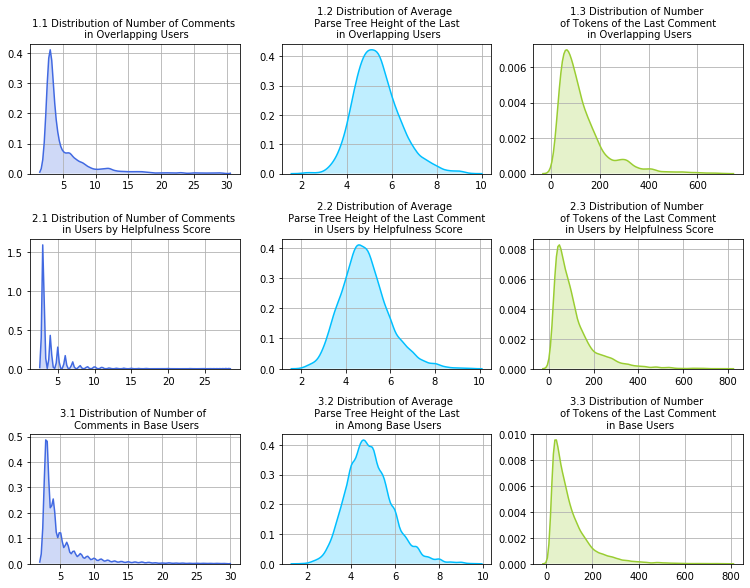

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(11, 8.5))
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.9, wspace=0.2, hspace=0.5)

axes[0, 0].set_title("1.1 Distribution of Number of Comments \n in Overlapping Users", fontsize=10)
axes[0, 1].set_title("1.2 Distribution of Average \n Parse Tree Height of the Last \n in Overlapping Users", fontsize=10)
axes[0, 2].set_title("1.3 Distribution of Number \n of Tokens of the Last Comment \n in Overlapping Users", fontsize=10)
axes[1, 0].set_title("2.1 Distribution of Number of Comments \n in Users by Helpfulness Score", fontsize=10)
axes[1, 1].set_title("2.2 Distribution of Average \n Parse Tree Height of the Last Comment \n in Users by Helpfulness Score", fontsize=10)
axes[1, 2].set_title("2.3 Distribution of Number \n of Tokens of the Last Comment \n in Users by Helpfulness Score", fontsize=10)
axes[2, 0].set_title("3.1 Distribution of Number of \n Comments in Base Users", fontsize=10)
axes[2, 1].set_title("3.2 Distribution of Average \n Parse Tree Height of the Last \n in Among Base Users", fontsize=10)
axes[2, 2].set_title("3.3 Distribution of Number \n of Tokens of the Last Comment \n in Base Users", fontsize=10)

A = np.array(list(overlapping_users_number_of_comments.values()))
sns.kdeplot(A, shade=True, color="royalblue", clip=(0, 30), ax=axes[0, 0])

B = np.array(list(helpfulness_users_number_of_comments.values()))
sns.kdeplot(B, shade=True, color="royalblue", clip=(0, 30), ax=axes[1, 0])

C = np.array(list(base_users_number_of_comments.values()))
sns.kdeplot(C, shade=True, color="royalblue", clip=(0, 30), ax=axes[2, 0])

sns.kdeplot(tree_height_last_comment_overlapping_users, shade=True, color="deepskyblue", clip=(0, 10), 
                                                        ax=axes[0, 1])

sns.kdeplot(tree_height_last_comment_helpfulness_users, shade=True, color="deepskyblue", clip=(0, 10), 
                                                        ax=axes[1, 1])

sns.kdeplot(tree_height_last_comment_base_users, shade=True, color="deepskyblue", clip=(0, 10), 
                                                        ax=axes[2, 1])

sns.kdeplot(tokens_last_comment_overlapping_users, shade=True, color="yellowgreen", clip=(0, 800), 
                                                        ax=axes[0, 2])

sns.kdeplot(tokens_last_comment_helpfulness_users, shade=True, color="yellowgreen", clip=(0, 800), 
                                                        ax=axes[1, 2])

sns.kdeplot(tokens_last_comment_base_users, shade=True, color="yellowgreen", clip=(0, 800), 
                                                        ax=axes[2, 2])

for i in range(3):
    axes[i ,0].xaxis.set_major_locator(MultipleLocator(5))
    axes[i ,0].xaxis.set_major_formatter(FormatStrFormatter('%d'))
    axes[i ,0].grid(which='major')

for i in range(3):
    axes[i ,1].xaxis.set_major_locator(MultipleLocator(2))
    axes[i ,1].xaxis.set_major_formatter(FormatStrFormatter('%d'))
    axes[i ,1].grid(which='major')

for i in range(3):
    axes[i ,2].xaxis.set_major_locator(MultipleLocator(200))
    axes[i ,2].xaxis.set_major_formatter(FormatStrFormatter('%d'))
    axes[i ,2].grid(which='major')

fig.savefig("NLP_final_project_graph.pdf", facecolor=fig.get_facecolor(), edgecolor ='black')


The plot below shows different distribution of the similarity score and the number of days elapsed between the earliest and the latest comments for the 3 groups of users. I expect improving users have smaller similarity scores because their commenting style should improve, thus differ, from their initial commenting style. I also expect improving users have larger number of days elapsed between their first and last comment, because they need time to improve. We can see, the helpfulness score fails again to identify this group of users, on the other hand, the overlapping users exhibit the characteristics of improving users. 

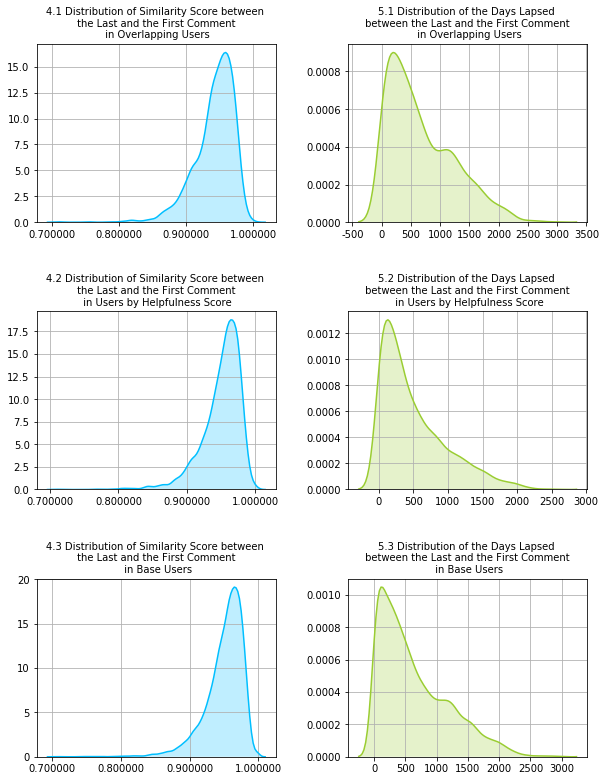

In [20]:

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8.5, 11))
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.3, hspace=0.5)

axes[0, 0].set_title("4.1 Distribution of Similarity Score between \n the Last and the First Comment \n in Overlapping Users", fontsize=10)
axes[1, 0].set_title("4.2 Distribution of Similarity Score between \n the Last and the First Comment \n in Users by Helpfulness Score", fontsize=10)
axes[2, 0].set_title("4.3 Distribution of Similarity Score between \n the Last and the First Comment \n in Base Users", fontsize=10)
axes[0, 1].set_title("5.1 Distribution of the Days Lapsed \n between the Last and the First Comment \n in Overlapping Users", fontsize=10)
axes[1, 1].set_title("5.2 Distribution of the Days Lapsed \n between the Last and the First Comment \n in Users by Helpfulness Score", fontsize=10)
axes[2, 1].set_title("5.3 Distribution of the Days Lapsed \n between the Last and the First Comment \n in Base Users", fontsize=10)


sns.kdeplot(sim_score_last_comment_overlapping_users, shade=True, color="deepskyblue", clip=(0.7, 1), 
                                                        ax=axes[0, 0])

sns.kdeplot(sim_score_last_comment_helpfulness_users, shade=True, color="deepskyblue", clip=(0.7, 1), 
                                                        ax=axes[1, 0])

sns.kdeplot(sim_score_last_comment_base_users, shade=True, color="deepskyblue", clip=(0.7, 1),
                                                        ax=axes[2, 0])

sns.kdeplot(time_lapsed_overlapping_users, shade=True, color="yellowgreen", clip=(0, 3000), 
                                                        ax=axes[0, 1])

sns.kdeplot(time_lapsed_helpfulness_users, shade=True, color="yellowgreen", clip=(0, 3000), 
                                                        ax=axes[1, 1])

sns.kdeplot(time_lapsed_base_users, shade=True, color="yellowgreen", clip=(0, 3000), 
                                                        ax=axes[2, 1])

for i in range(3):
    axes[i ,0].xaxis.set_major_locator(MultipleLocator(0.1))
    axes[i ,0].xaxis.set_major_formatter(FormatStrFormatter('%f'))
    axes[i ,0].grid(which='major')

for i in range(3):
    axes[i ,1].xaxis.set_major_locator(MultipleLocator(500))
    axes[i ,1].xaxis.set_major_formatter(FormatStrFormatter('%d'))
    axes[i ,1].grid(which='major')

fig.savefig("NLP_final_project_graph_2.pdf", facecolor=fig.get_facecolor(), edgecolor ='black')

#### 8. Conclusion

The entire study shows that using three simple criteria: word token length, average dependency parse tree height and similarity scores, I am able to filter out a groups of users who consistently improving in their reviewing abilities. Even though this algorithm is not as fancy as the one in the literature as I cannot determine which stage a user is right now in his or her journey of becoming a connoisseur. In fact, the evaluation is self-proving since I set the filterning algorithm so. I only proved that the helpfulness score is not an objective criterion for identifying improving users. This makes sense because we are missing data on the helpfulness score denominator, and using number of reviews as the denominator is a bad substitute. 

Two issues that could be improved are: use abstract syntax tree instead of parse tree, and it may more accurately reflect sentence complexity by including just meaningful tokens; text pre-process before applying Spacy similarity method to ensure words in either review are specific to the review itself. 

Further research can be conducted by developing an more objective criteria for identifying improving users, and I could incorporate a more complex statistical model that would determine not only who are the improving users, but also those are likely to become improving users in the future. Thus, the potential improving users would be targeted by more relevant advertisement. 

#### 9. References

_"From Amateurs to Connoisseurs: Modeling the Evolution of User Expertise through Online Reviews"_ Julian McAuley and Jure Leskovec. WWW 2013, May 13–17, 2013, Rio de Janeiro, Brazil.

_Amazon Fine Food Review_. Kaggle Dataset by Stanford Network Analysis Project. 
https://www.kaggle.com/snap/amazon-fine-food-reviews

Github Page: _drussellmrichie/average_parse_tree_height.py_
https://gist.github.com/drussellmrichie/47deb429350e2e99ffb3272ab6ab216a